## Descriptive Analytics

### Import Libraries

In [17]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt

### Import Data

In [18]:
charging_sessions_data = pd.read_csv("cleaned_data.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

### Operational Performance and Statistics on Charging Hubs
1. **Temporal Patterns and Seasonality**
* Demonstrate in a figure how the number of charging events varies during *the day, the week and between seasons*
- day **(Karoline)**
- week **(Marietta)**
- seasons (-)
* Note down observed patterns and possible explaination for them
2. **Key Performance Indicators (KPIs)**
* Define three time-dependent KPIs (to include in a dashboard for the hub operator):
    1. Peak and Off-Utilization Time (per Site) **(Marietta)**
    2. Idle Time per Hour per SiteID (disconnect - chargingdone) **(Angela)**
    3. Average Energy Deliverd per Session per SiteID per Hour **(CoCo)**
* Requirements for KPIs:
    * Must provide an immediate overview of the current hub operation
    * Show how the hub operation is doing in terms of *utilization or other business-related aspects*
* Provide explaination for each KPI selection in relation to the requirements and if necessary provide references
* Calculate *hourly values* for the KPIs and visualize them over time
* Note down observed trends and possible explainations for them
3. **Site Characteristics** ***(Simon)***
* Find out which of the two sites is supplying the private and public charging hub data
* Combine data from the tasks before to determine the difference in the operation of private and public charging hub data
* Note down explanation and reasoning behind the decision

### 1. Temporal Patterns and Seasonality

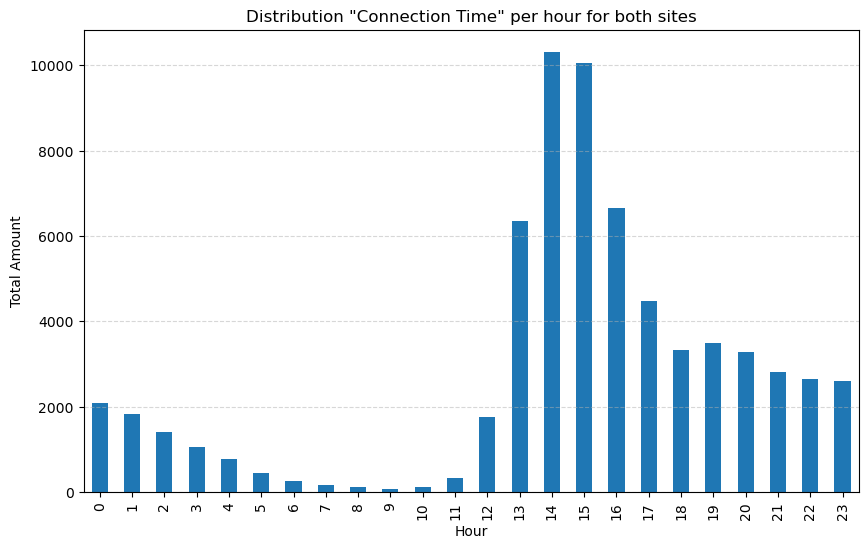

<Figure size 1400x600 with 0 Axes>

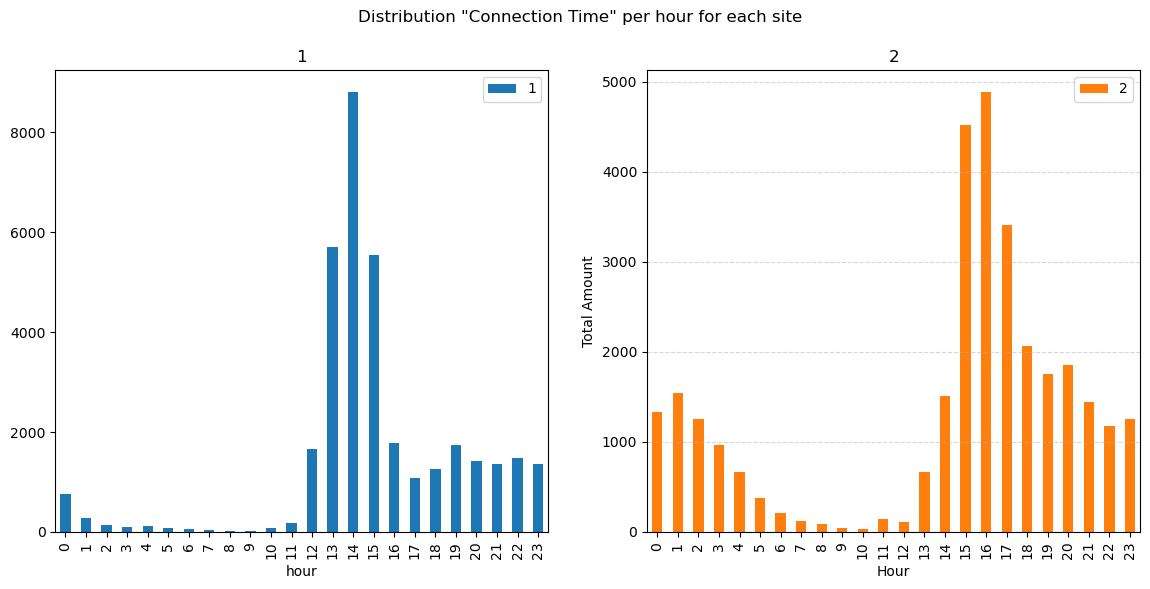

<Figure size 1400x600 with 0 Axes>

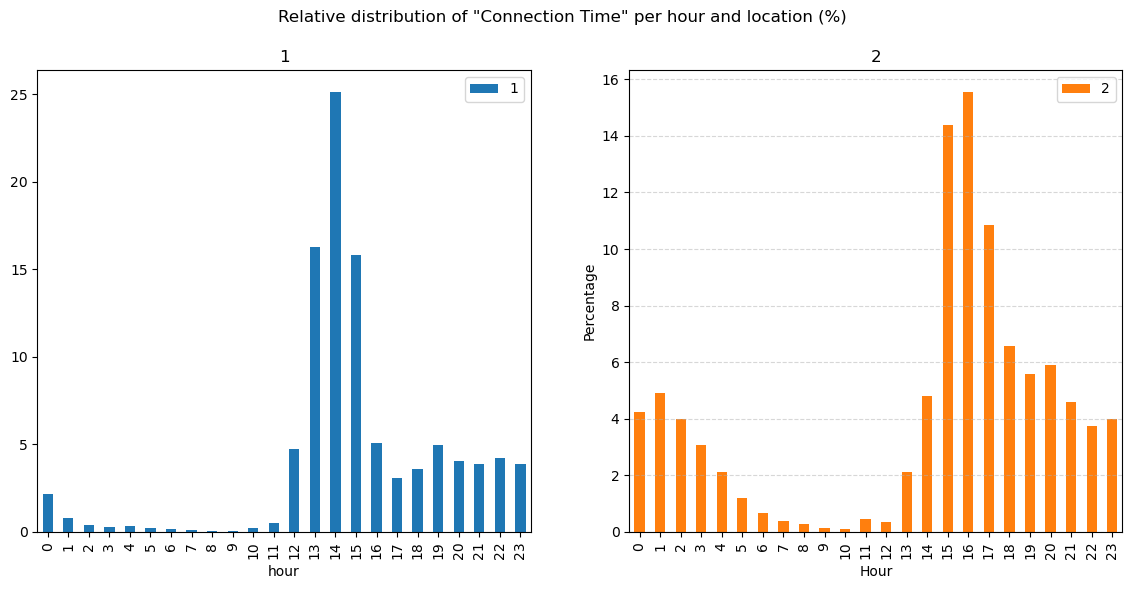

In [19]:
# Demonstrate how the number of charging events varies during the day

# Convert time into datetime
charging_sessions_data['connectionTime'] = pd.to_datetime(charging_sessions_data['connectionTime'])

# Retrieve the hour
charging_sessions_data['hour'] = charging_sessions_data['connectionTime'].dt.hour

# Count the frequency per hour
hourly_counts = charging_sessions_data['hour'].value_counts().sort_index()

# Calculation of the absolute distribution per hour and location
absolute_counts = charging_sessions_data.groupby('siteID')['hour'].value_counts().unstack(fill_value=0).sort_index()

# Calculation of the relative distribution (percentage)
relative_counts = absolute_counts.div(absolute_counts.sum(axis=1), axis=0) * 100

# Plotting the distribution
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar')
plt.title('Distribution "Connection Time" per hour for both sites')
plt.xlabel('Hour')
plt.ylabel('Total Amount')
plt.xticks(range(24), labels=range(24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(14, 6))
absolute_counts.T.plot(kind='bar', subplots=True, layout=(1, 2), figsize=(14, 6), legend=True)
plt.suptitle('Distribution "Connection Time" per hour for each site')
plt.xlabel('Hour')
plt.ylabel('Total Amount')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.figure(figsize=(14, 6))
relative_counts.T.plot(kind='bar', subplots=True, layout=(1, 2), figsize=(14, 6), legend=True)
plt.suptitle('Relative distribution of "Connection Time" per hour and location (%)')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [20]:
# Demonstrate how the number of charging events varies during the week


<Figure size 1200x600 with 0 Axes>

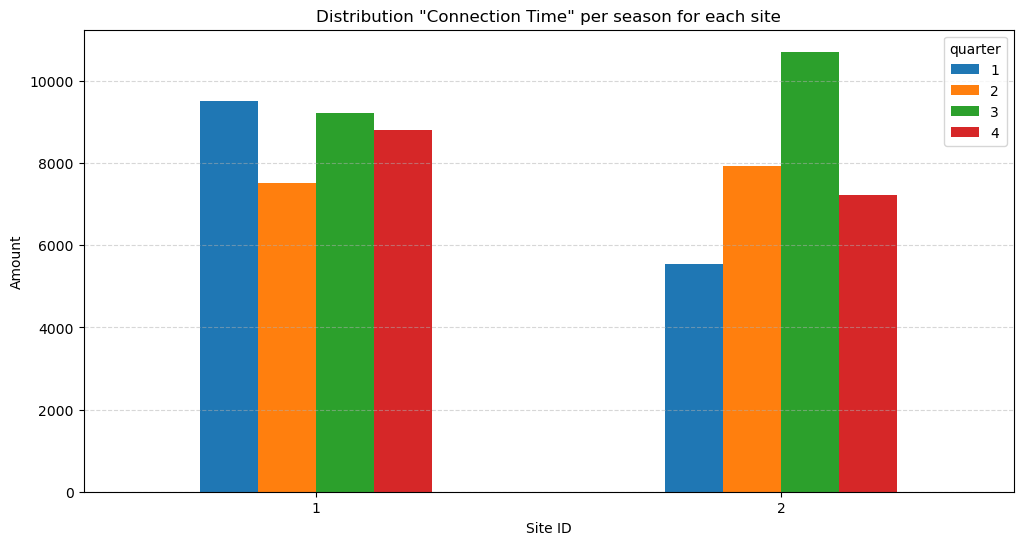

<Figure size 1200x600 with 0 Axes>

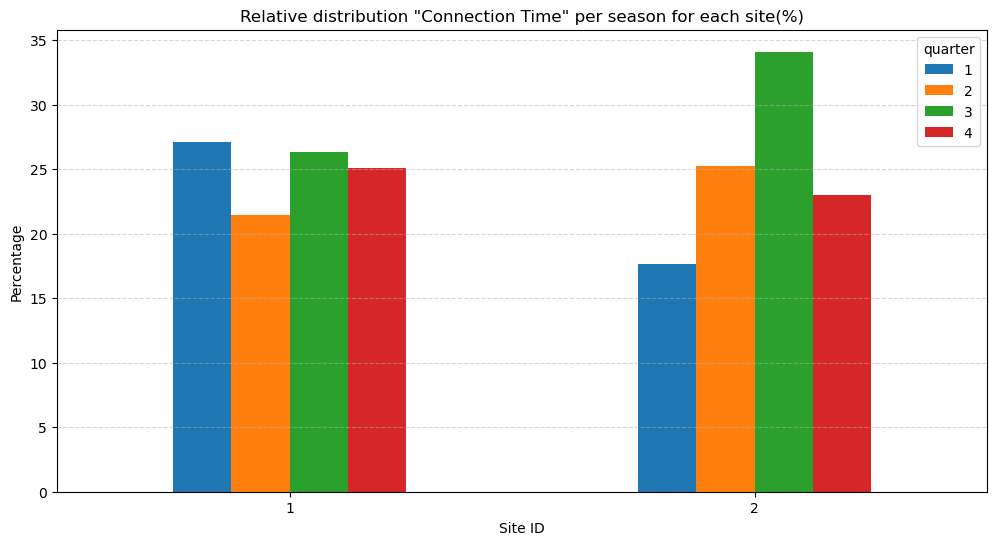

In [21]:
# Demonstrate how the number of charging events varies between the seasons
# The seasons in Los Angeles correspond to the quarters approximately, which is why these were used as a divider. 

# Convert time into datetime
charging_sessions_data['connectionTime'] = pd.to_datetime(charging_sessions_data['connectionTime'])

# Retrieve the quarter
charging_sessions_data['quarter'] = charging_sessions_data['connectionTime'].dt.quarter

# Calculation of the absolute distribution per quarter and location
absolute_counts_quarter_site = charging_sessions_data.groupby(['siteID', 'quarter']).size().unstack(fill_value=0)

# Calculation of the relative distribution (percentage) per location
relative_counts_quarter_site = absolute_counts_quarter_site.div(absolute_counts_quarter_site.sum(axis=1), axis=0) * 100

# Plotting the absolute distribution
plt.figure(figsize=(12, 6))
absolute_counts_quarter_site.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution "Connection Time" per season for each site')
plt.xlabel('Site ID')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Plotting the relative distribution
plt.figure(figsize=(12, 6))
relative_counts_quarter_site.plot(kind='bar', figsize=(12, 6))
plt.title('Relative distribution "Connection Time" per season for each site(%)')
plt.xlabel('Site ID')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Observed Trends are ...

### 2. Key Performance Indicators (KPIs)

We have choosen the following three time-dependent KPIs [...] because [...].

In [22]:

# Calculate hourly values of the KPI - Peak and Off-Utilization Time (per Site)
from datetime import datetime, timedelta 

# Create a DataFrame from the provided charging sessions data 
df = pd.DataFrame(charging_sessions_data)

# Convert 'connectionTime' and 'disconnectTime' columns from string to datetime objects.
# Note: This step is already done in Data_Preparation, so we can drop this if it is exported
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

# Get unique site IDs
site_ids = df['siteID'].unique()

# Dictionary to store the results for each siteID
utilization_per_site = {}

# Iterate over each siteID
for site in site_ids:
    # Filter DataFrame for the current siteID -> site is either 1 or 2
    site_number = df[df['siteID'] == site]

    # Initialize an array to store the occupied minutes and the count of occupied minutes for each hour of the day.
    # The array will have 24 elements (one for each hour of the day, from 0 to 23).
    # Each element is a list where:
    # - index 0 will store the total number of occupied minutes in that hour.
    # - index 1 will store the count of occupied minutes (i.e., how many times a minute was occupied)
    minutes_array = [[0.0, 0.0] for _ in range(24)]  # Initialize each hour with [0.0, 0.0] (minutes, count)

    # Iterate through the DataFrame for site == 1 or for site == 2
    for row in site_number.itertuples():
        # Extract sessionID, connectionTime, and disconnectTime for each charging session
        sessionid = row.sessionID
        currenttime = row.connectionTime
        endtime = row.disconnectTime
        
        # Extract the hour and minute from the connectionTime and disconnectTime
        currenttimeStunde = currenttime.hour
        currenttimeMinute = currenttime.minute
        endtimeStunde = endtime.hour
        endtimeMinute = endtime.minute
        
        while currenttime < endtime:  # Keep going until we reach the disconnect time
            minutes_array[currenttimeStunde][0] += currenttimeMinute  # Add the minute to the corresponding hour in the minutes_array
            minutes_array[currenttimeStunde][1] += 1  # Increment the count for occupied minutes in this hour
        
            # Move to the next minute.
            if currenttime.minute == 59: # If it's the last minute of the hour
                if currenttime.hour == 23: # If it's also the last hour (23), we need to roll over to the next day.
                    currenttime = currenttime + timedelta(minutes=1) # Add 1 minute to move to the next day, reset the hour to 0 -> for that we imported timedelta
                else:
                    # Otherwise move to the next hour while resetting the minutes to 0
                    currenttime = currenttime.replace(minute=0, hour=currenttime.hour + 1)
            else:
                # If the minute is not 59, only increase the minute by 1
                currenttime = currenttime.replace(minute=currenttime.minute + 1)
                
        # print(f"Session ID: {sessionid}")
        # print(f"  Connection Time - Stunde: {connectiontimeStunde}, Minute: {connectiontimeMinute}")

    #print(minutes_array)

    # Now: Calculation of the hourly utilization

    # New array to store the hourly utilization (in percentage)
    utilizationPerHour_array = []

    # Iterate through all hours from 0 to 23 (the index corresponds to each hour of the day)
    for index in range(24):  
        occupied_minutes = minutes_array[index][0]  # Total occupied minutes in this hour
        count = minutes_array[index][1]  # Number of occupied minutes (i.e., how many times minutes were occupied)
        
        # Calculate the utilization percentage, but only if count > 0 (so no division by 0)
        if count > 0:
            utilization = (occupied_minutes / (count * 60)) * 100  # utilization in percentage 
        else:
            utilization = 0  # If no minutes were occupied, utilization = 0%
        
        # Append the calculated utilization for this hour to the list
        utilizationPerHour_array.append(utilization)
    
    # Store the results in the dictionary
    utilization_per_site[site] = utilizationPerHour_array

# print for each site
for site, utilizationPerHour_array in utilization_per_site.items():
    print(f"\nSite {site}:")
    for index, utilization in enumerate(utilizationPerHour_array):
        print(f"hour {index}: {utilization:.2f}% Utilization")



Site 1:
hour 0: 39.25% Utilization
hour 1: 41.90% Utilization
hour 2: 43.97% Utilization
hour 3: 41.99% Utilization
hour 4: 50.54% Utilization
hour 5: 52.67% Utilization
hour 6: 50.15% Utilization
hour 7: 41.02% Utilization
hour 8: 54.57% Utilization
hour 9: 55.45% Utilization
hour 10: 69.42% Utilization
hour 11: 69.54% Utilization
hour 12: 67.40% Utilization
hour 13: 57.20% Utilization
hour 14: 46.37% Utilization
hour 15: 41.62% Utilization
hour 16: 41.46% Utilization
hour 17: 46.32% Utilization
hour 18: 52.20% Utilization
hour 19: 48.42% Utilization
hour 20: 47.10% Utilization
hour 21: 50.11% Utilization
hour 22: 48.69% Utilization
hour 23: 43.64% Utilization

Site 2:
hour 0: 47.07% Utilization
hour 1: 51.62% Utilization
hour 2: 49.30% Utilization
hour 3: 46.25% Utilization
hour 4: 47.48% Utilization
hour 5: 47.17% Utilization
hour 6: 36.62% Utilization
hour 7: 45.59% Utilization
hour 8: 43.71% Utilization
hour 9: 43.19% Utilization
hour 10: 50.43% Utilization
hour 11: 77.69% Utiliz

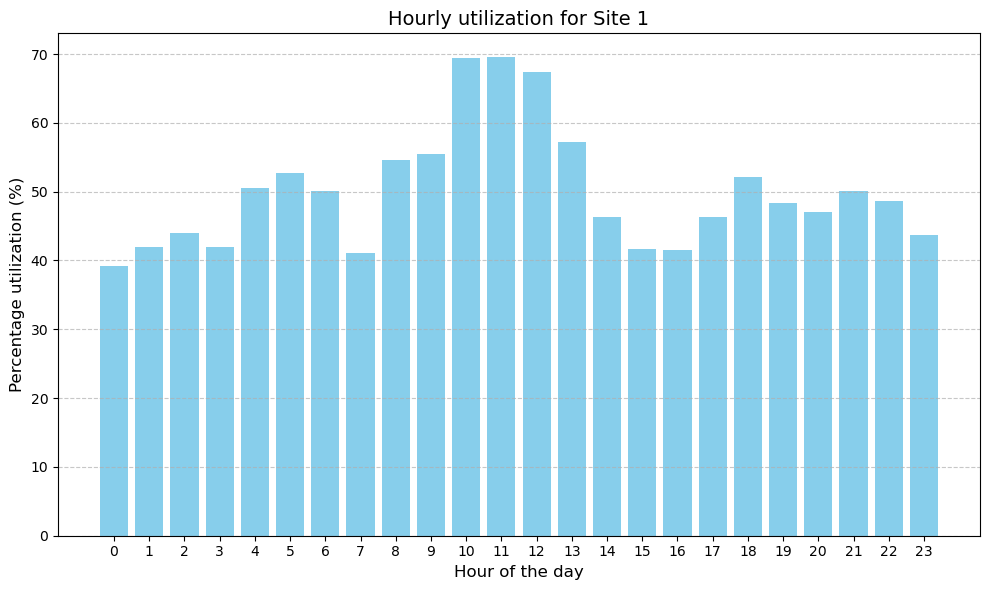

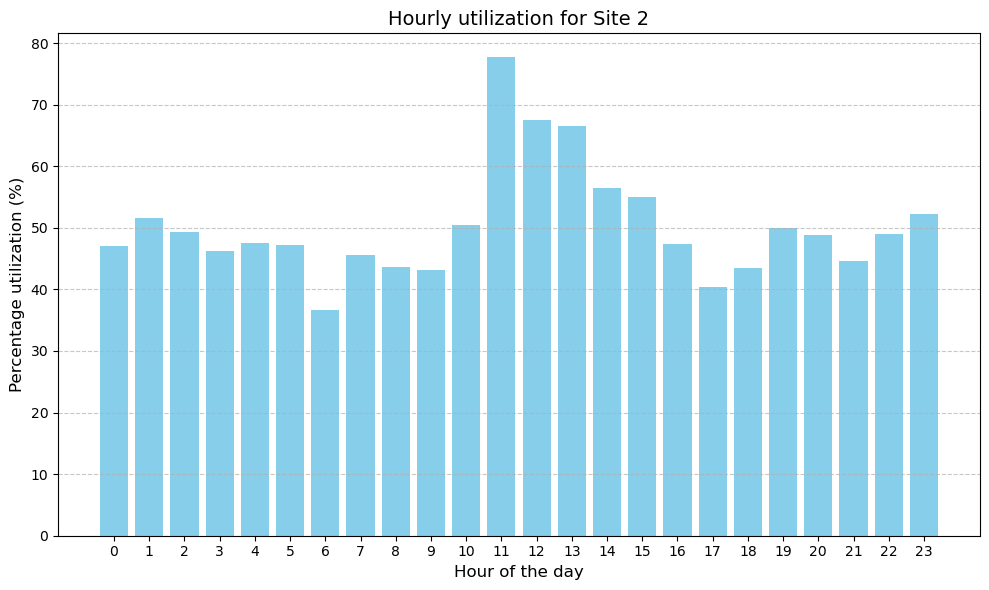

In [23]:
# Visualize hourly values of the KPIs over time

# bar chart

import matplotlib.pyplot as plt # import the necessary library for visualization

# Create a list representing the hours of the day (0 to 23) for the x-axis
hours = list(range(24))

#iterate over the siteIds
for site in site_ids:

    #array for the current site
    utilizationPerHour_array = utilization_per_site[site]

    # Create a bar chart 
    plt.figure(figsize=(10, 6))  

    # Plot the bar chart using the hours as the x-axis and 'utilizationPerHour_array' as the y-axis values, set color blue
    plt.bar(hours, utilizationPerHour_array, color='skyblue')

    # Axis labelling and titles
    plt.xlabel('Hour of the day', fontsize=12)
    plt.ylabel('Percentage utilization (%)', fontsize=12)
    plt.title(f'Hourly utilization for Site {int(site)}', fontsize=14)

    plt.xticks(hours)  # Ensure that all hours (0 to 23) are shown on the X-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid to the Y-axis to make the chart easier to read (dashed lines, light opacity)

    plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements
    plt.show() # Display the plot

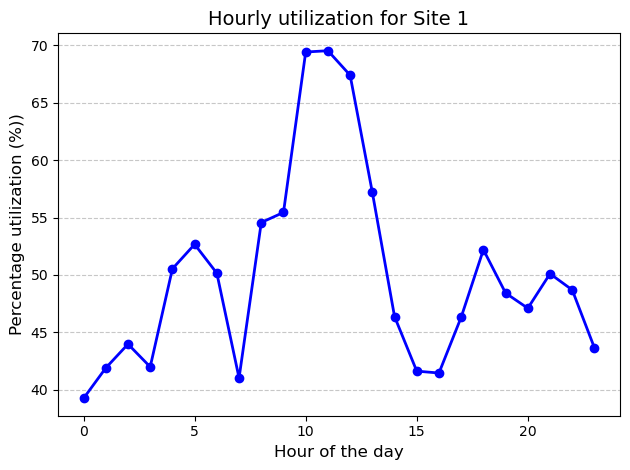

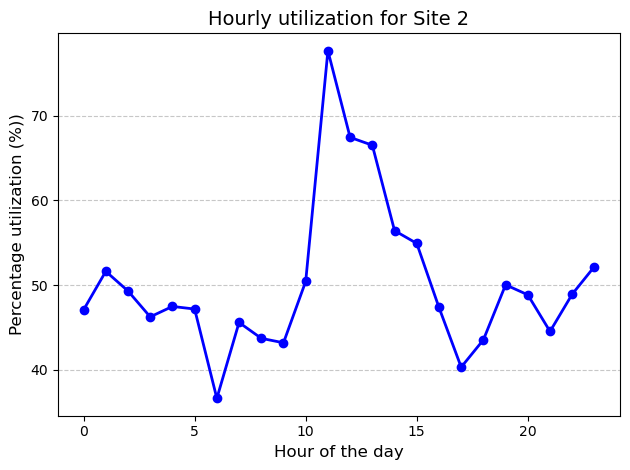

In [24]:
# linechart

#iterate over the siteIds
for site in site_ids:

    #array for the current site
    utilizationPerHour_array = utilization_per_site[site]
    
    # Create a line chart
    plt.plot(hours, utilizationPerHour_array, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

    # Axis labelling and titles
    plt.xlabel('Hour of the day', fontsize=12)
    plt.ylabel('Percentage utilization (%))', fontsize=12)
    plt.title(f'Hourly utilization for Site {int(site)}', fontsize=14)

    # Add a grid to the Y-axis to make the chart easier to read (dashed lines, light opacity)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements
    plt.show() # Display the plot

2.3 Average Energy Delivered per Session per Site per Hour

In [ ]:
# split dataframe into 2 sites
site1_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 1]
site2_sessions = charging_sessions_data[charging_sessions_data["siteID"] == 2]

# function that filters data by hour
def filterSessionsByHour(hour, df):
    hour = df[df['connectionTime'].dt.hour == hour]
    return hour

def avgEnergyToList(df):
    energyList = []
    for i in range(24):
        hour = filterSessionsByHour(i, df)
        totalEnergy = hour.kWhDelivered.sum()
        # calculute average energy by summing up energy delivered in the hour and dividing by number of sessions
        avgEnergy = totalEnergy / len(hour) 
        energyList.append(avgEnergy)
    return energyList

energyList_site1 = avgEnergyToList(site1_sessions)
energyList_site2 = avgEnergyToList(site2_sessions)


2.3 Average Energy Delivered per Session per Site per Hour

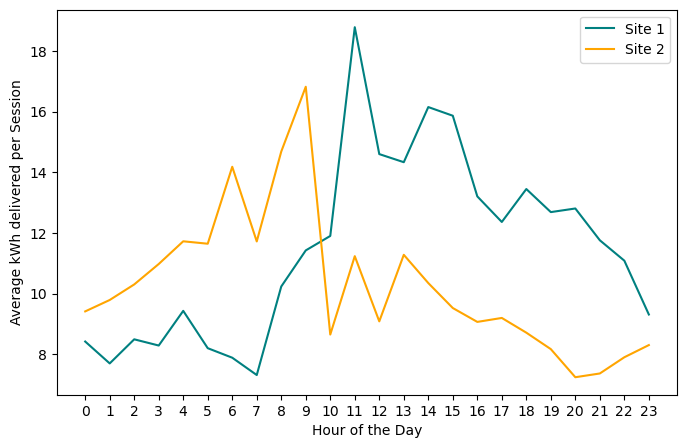

In [ ]:
# visualize average energy
import matplotlib.pyplot as plt
import numpy as np

hours = range(24)
y_1 = np.array(energyList_site1)
y_2 = np.array(energyList_site2)

plt.figure(figsize=(8, 5))
plt.plot(hours, y_1, color = "teal", label='Site 1')
plt.plot(hours, y_2, color = "orange", label='Site 2')
plt.xticks(range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Average kWh delivered per Session")
plt.legend()
plt.show()

[58.43, 72.46, 73.29, 72.53, 75.44, 73.97, 88.24, 95.0, 72.22, 93.1, 84.42, 66.13, 76.24, 72.77, 69.32, 66.45, 74.64, 73.6, 70.02, 71.22, 69.78, 67.67, 59.57, 59.47]
[83.65, 83.54, 83.59, 81.06, 77.25, 78.4, 64.81, 75.81, 68.13, 58.97, 89.29, 94.48, 80.91, 86.84, 85.0, 86.55, 86.32, 85.81, 85.17, 84.96, 84.97, 85.42, 85.82, 83.04]


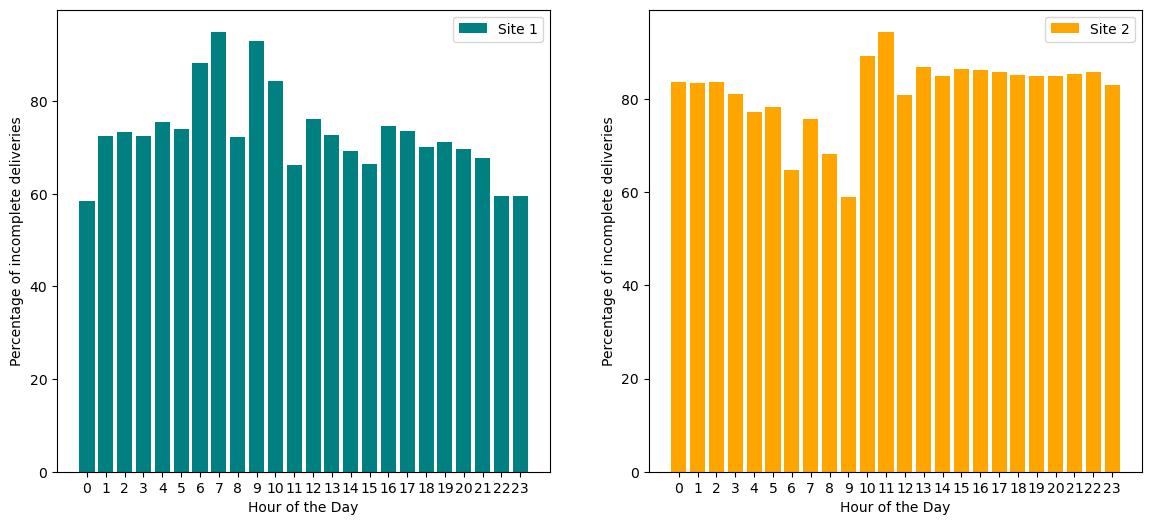

In [63]:
# An incomplete delivery is defined by a session that delivered less energy than requested, 
# although driver disconnected after charging was done
def underDeliveredToList(df):
    percentageList = []
    for i in range(24):
        hour = filterSessionsByHour(i, df)
        imcompleteSess = hour[(hour['kWhDelivered'] < hour['kWhRequested']) & (hour['disconnectTime'] >= hour['doneChargingTime']) ]
        percentage = round(len(imcompleteSess) / len(hour) * 100,2)
        percentageList.append(percentage)
    return percentageList


incompleteDelivery_site1 = underDeliveredToList(site1_sessions)
incompleteDelivery_site2 = underDeliveredToList(site2_sessions)

print(incompleteDelivery_site1)
print(incompleteDelivery_site2)

hours = range(24)
y_1 = np.array(incompleteDelivery_site1)
y_2 = np.array(incompleteDelivery_site2)

plt.figure(figsize=(14, 6)) 

plt.subplot(1, 2, 1)
plt.bar(hours, y_1, color = "teal", label='Site 1')
plt.xticks(range(24), labels=range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage of incomplete deliveries")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(hours, y_2, color = "orange", label='Site 2')
plt.xticks(range(24), labels=range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Percentage of incomplete deliveries")

plt.legend()
plt.show()

### 3. Site Characteristics

In [25]:
# Determine which of the two sites provided public or private data


The data with ... is public because ...